# Saving Experiment Data to the Cloud

Qiskit Experiments is designed to work with Qiskit's online experiment database, where you can view and share results of experiments you've run. This tutorial shows how to save your experimental results to the database. You will need to have `qiskit-ibmq-provider` installed locally and an account in the Qiskit cloud service. We will use the `ibmq_armonk` backend which is open and available to everyone.

In [2]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
backend = provider.get_backend("ibmq_armonk")

## T1 Experiment

Let's run a T1 experiment and save the results to the experiment database.

In [3]:
from qiskit_experiments.library.characterization import T1

t1_delays = list(range(0, 800, 50))

# Create an experiment for qubit 0,
# setting the unit to microseconds,
# with the specified time intervals
exp = T1(qubit=0, delays=t1_delays, unit="us")
print(exp.circuits()[0])

     ┌───┐ ░ ┌──────────────┐ ░ ┌─┐
q_0: ┤ X ├─░─┤ Delay(0[us]) ├─░─┤M├
     └───┘ ░ └──────────────┘ ░ └╥┘
c: 1/════════════════════════════╩═
                                 0 


Let's run the experiment. `block_for_results()` blocks execution until the experiment is complete, then `save()` is called to save the data to ResultsDB.

In [4]:
# Run the experiment circuits with 1000 shots each,
# and analyze the result

t1_expdata = exp.run(backend=backend, shots=1000)

t1_expdata.block_for_results()
t1_expdata.save()

Note that calling `save()` before the experiment is complete will instantiate an experiment entry in the database, but it will not have complete data. To fix this, you can call `save()` again once the experiment is done running.

Our T1 figure and analysis results:

In [22]:
t1_expdata

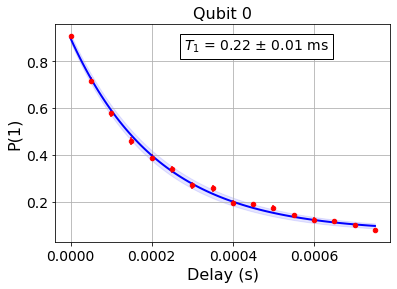

{'value': 0.00021540042996137575,
 'stderr': 7.413214470196464e-06,
 'unit': 's',
 'label': 'T1',
 'fit': {'popt': array([8.27525912e-01, 2.15400430e-04, 7.05351749e-02]),
  'popt_keys': ['a', 'tau', 'c'],
  'popt_err': array([9.62076097e-03, 7.41321447e-06, 7.29076513e-03]),
  'pcov': array([[ 9.25590417e-05,  1.69155694e-08, -3.72037925e-05],
         [ 1.69155694e-08,  5.49557488e-11, -4.59738214e-08],
         [-3.72037925e-05, -4.59738214e-08,  5.31552561e-05]]),
  'reduced_chisq': 1.3609095467472334,
  'dof': 13,
  'xrange': [0.0, 0.00075],
  'circuit_unit': 'us'},
 'quality': 'bad',
 'success': True}

In [5]:
display(t1_expdata.figure(0))
t1_expdata.analysis_results(0).data()

You can also view the results at the [IBM Quantum Experiments pane](https://quantum-computing.ibm.com/experiments?date_interval=last-90-days&owner=me) on the cloud.

By default, the interface displays all experiments you have privilege to see, but this link shows your own experiments. You can change that setting by clicking on the All Experiments dropdown. You can also filter by device, date, provider, and result by clicking on the filter icon.

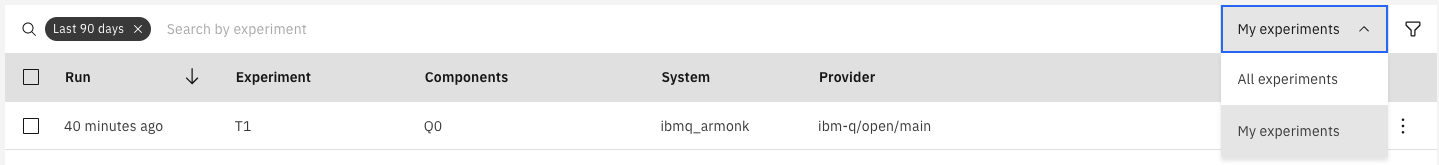

Individual experiment pages show the plot, and one or more important analysis results, which for the T1 experiment is the fitted T1 value.

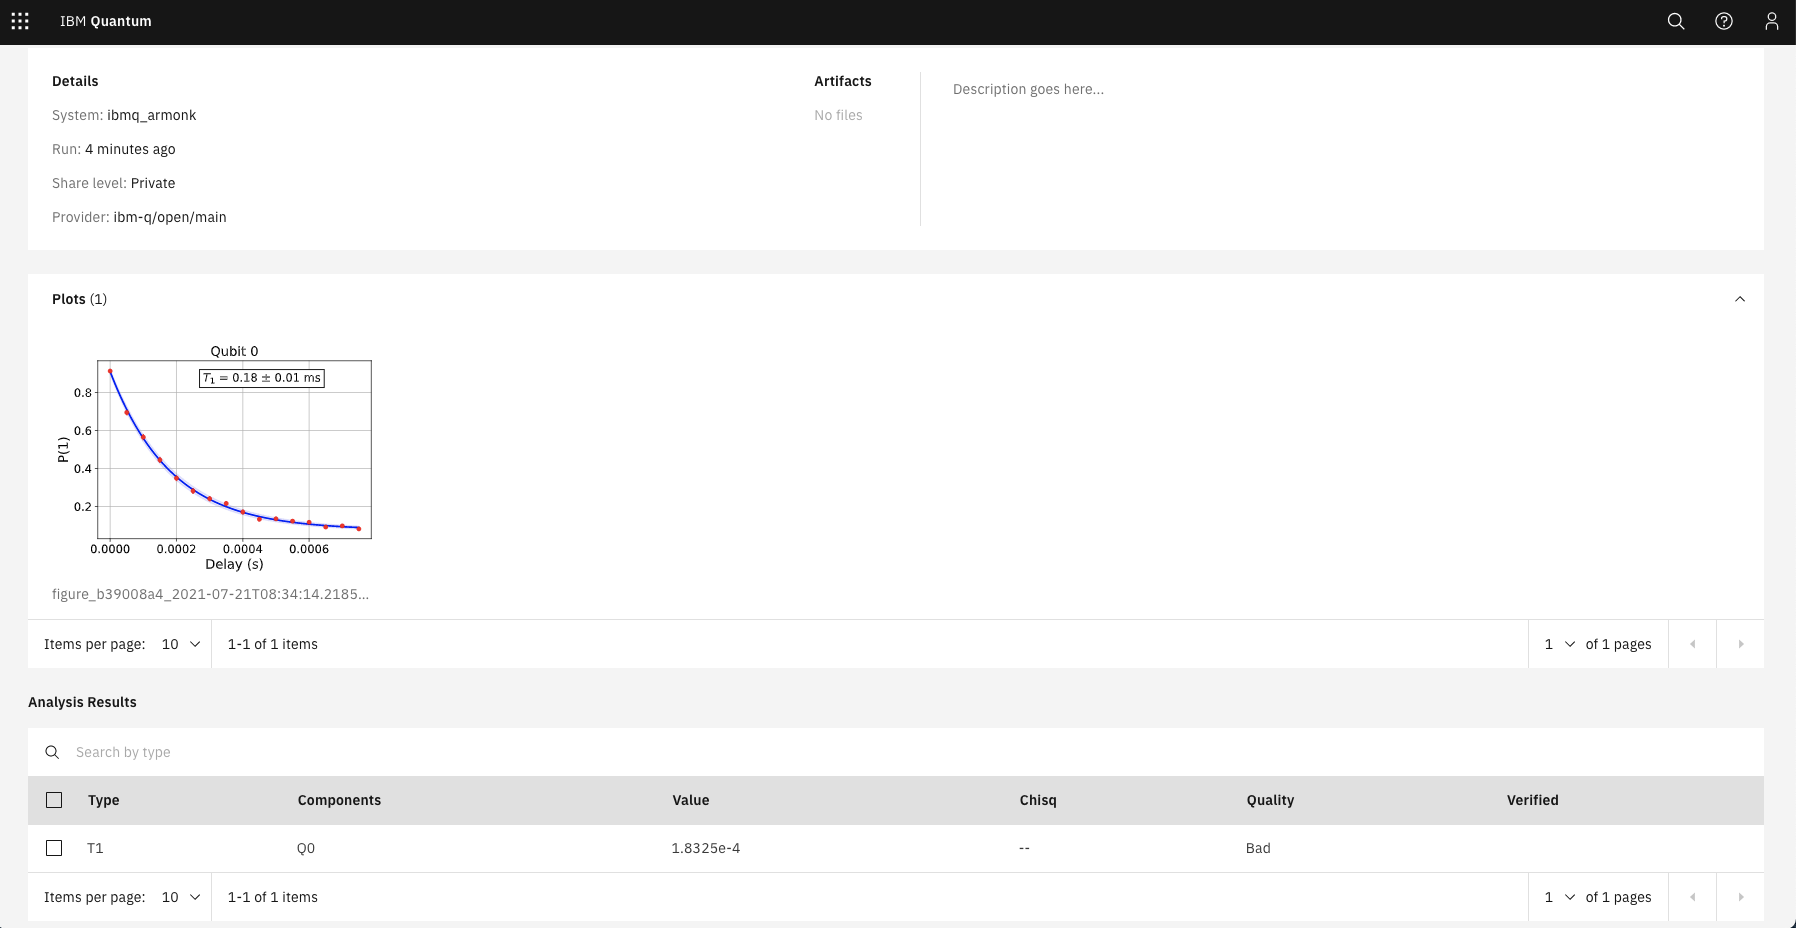

You can change the quality and verify/unverify the results upon selection:

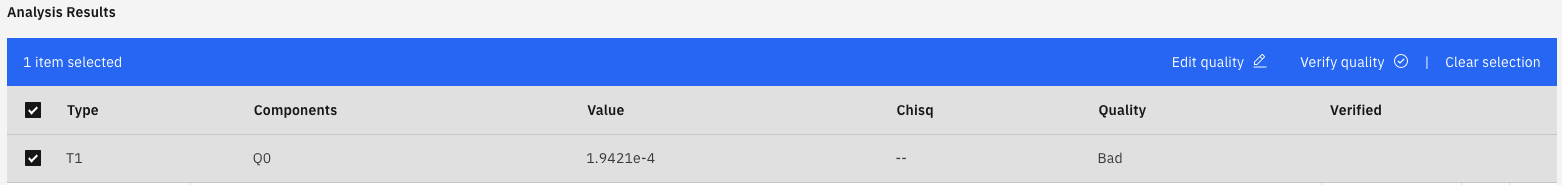

You can also load the full saved analysis result from the database service. Let's instantiate a dummy analysis result to load the result we've just saved to the database and check that it's the same as before:

In [51]:
from qiskit_experiments.database_service import DbAnalysisResultV1 as DbAnalysisResult

values = {
    "result_data": {"foo": "bar"},
    "result_type": "some_type",
    "device_components": ["Q1", "Q2"],
    "experiment_id": "1234",
}

analysis_res = DbAnalysisResult(**values)
data = analysis_res.load(t1_expdata.analysis_results(0).result_id, t1_expdata.service)

In [52]:
print(data)


Analysis Result: T1
Analysis Result ID: 5769261c-bf3f-4e2e-9754-0c0bec5b5e02
Experiment ID: 6cc66a03-de43-4d36-9c39-f56d5ee8c011
Device Components: [<Qubit(Q0)>]
Quality: ResultQuality.BAD
Verified: True
Result Data:{'fit': {'dof': 13, 'pcov': array([[ 9.25590417e-05,  1.69155694e-08, -3.72037925e-05],
       [ 1.69155694e-08,  5.49557488e-11, -4.59738214e-08],
       [-3.72037925e-05, -4.59738214e-08,  5.31552561e-05]]), 'popt': array([8.27525912e-01, 2.15400430e-04, 7.05351749e-02]), 'xrange': [0, 0.00075], 'popt_err': array([9.62076097e-03, 7.41321447e-06, 7.29076513e-03]), 'popt_keys': ['a', 'tau', 'c'], 'circuit_unit': 'us', 'reduced_chisq': 1.3609095467472334}, 'unit': 's', 'label': 'T1', 'value': 0.00021540042996137575, 'stderr': 7.413214470196464e-06, 'quality': 'bad', 'success': True}


There is also the `auto_save` feature, which saves the data of an experiment preemptively. In the future, you will be able to set `provider.experiment.set_option(auto_save=True)` to turn `auto_save` on by default at the experiment service level.

In [14]:
exp = T1(qubit=0, delays=t1_delays, unit="us")

t1_expdata = exp.run(backend=backend, shots=1000)
t1_expdata.auto_save = True
t1_expdata.block_for_results()

Not all post-processing has finished. Consider calling save() again after all post-processing is done to save any newly generated data.
Analysis result cannot be saved because no experiment service is available.


## RB Experiment
Let's now do a standard RB experiment and save the results to ResultsDB.

In [38]:
import numpy as np
import qiskit_experiments as qe

rb = qe.library.randomized_benchmarking

lengths = np.arange(1, 1000, 200)
num_samples = 10
seed = 1010

rb_exp = rb.StandardRB([0], lengths, num_samples=num_samples, seed=seed)
rb_expdata = rb_exp.run(backend)
rb_expdata.block_for_results()
rb_expdata.save()

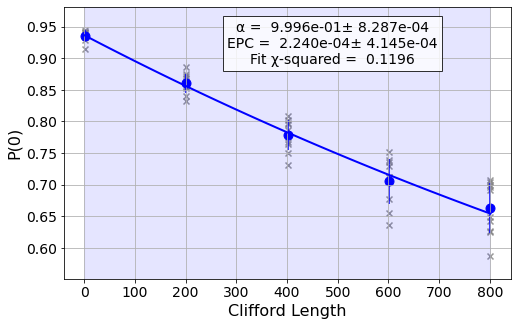

{'analysis_type': 'RBAnalysis',
 'popt': array([9.36670735e-01, 9.99551934e-01, 6.66037165e-14]),
 'popt_keys': ['a', 'alpha', 'b'],
 'popt_err': array([1.52118353e+00, 8.28652723e-04, 1.52343583e+00]),
 'pcov': array([[ 2.31399934e+00,  1.25843445e-03, -2.31739302e+00],
        [ 1.25843445e-03,  6.86665336e-07, -1.26048728e-03],
        [-2.31739302e+00, -1.26048728e-03,  2.32085673e+00]]),
 'reduced_chisq': 0.11955890357808392,
 'dof': 2,
 'xrange': [1.0, 801.0],
 'success': True,
 'EPC': 0.00022403283474575764,
 'EPC_err': 0.0004145120902580399,
 'EPG': {0: {'rz': 0.0,
   'sx': 7.250382396729012e-05,
   'x': 7.250382396729012e-05}}}

In [39]:
display(rb_expdata.figure(0))
rb_expdata.analysis_results(0).data()

Here is the view of the same job on the database service:

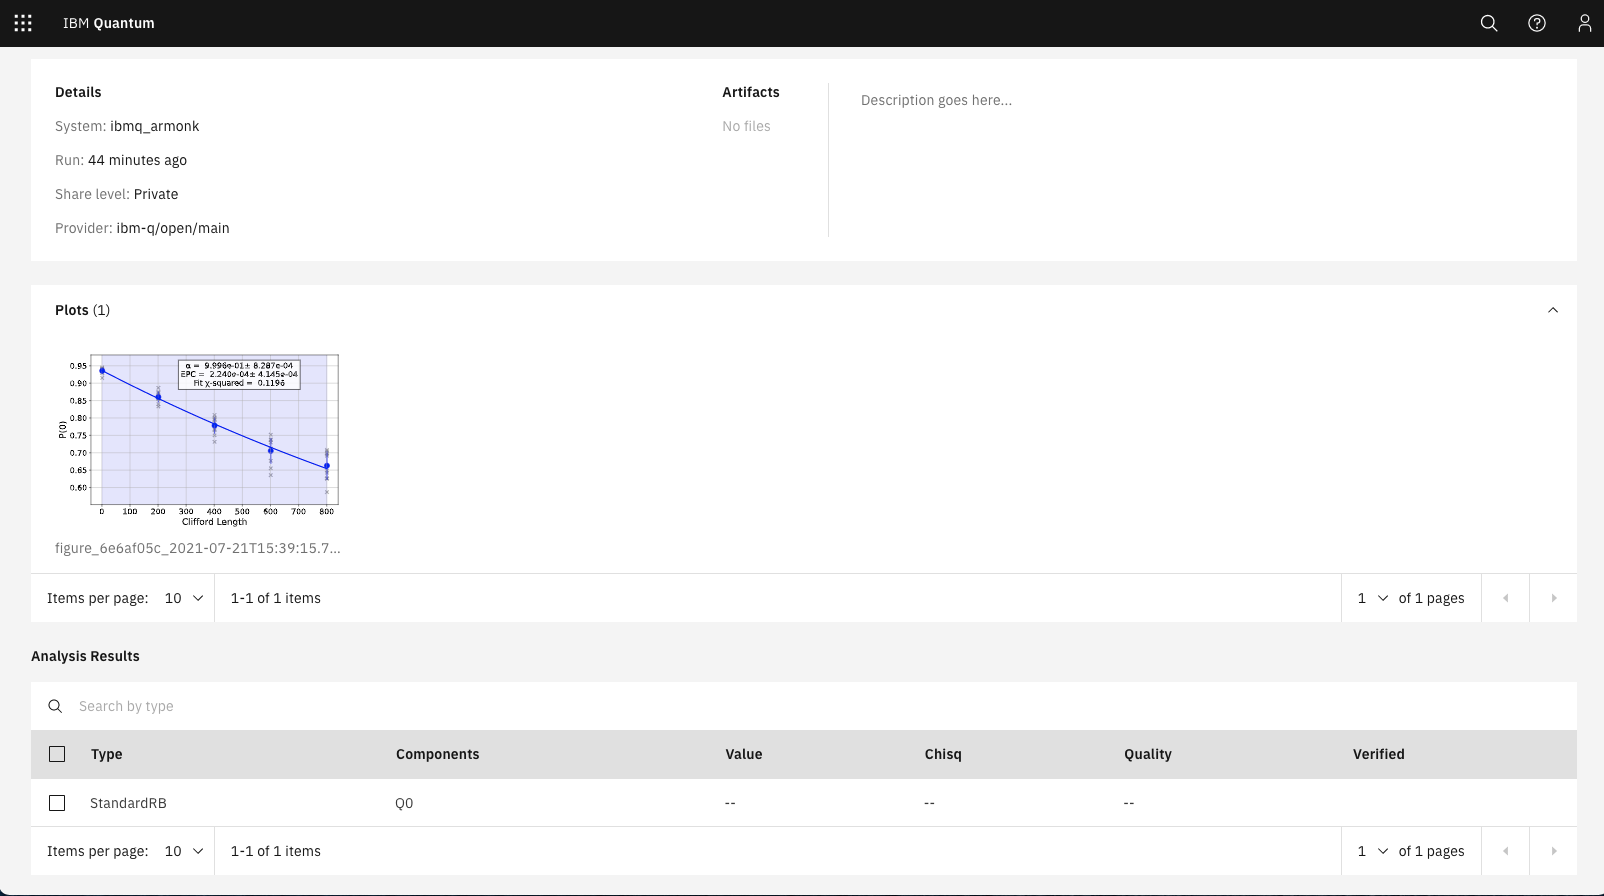